In [28]:
import torch
import random
from torch._tensor import Tensor
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [93]:
g = torch.Generator().manual_seed(2147483647)

random.seed(2147483647)

In [94]:
words = open('../../assets/names.txt', 'r').read().splitlines()

In [95]:
chars = sorted(list(set(''.join(words))))
stoi = {char: i + 1 for i, char in enumerate(chars)}
stoi['.'] = 0
itos = {i: char for char, i in stoi.items()}

In [96]:

block_size = 3

def build_dataset(words: list[str] ) -> tuple[Tensor, Tensor]:

    Inputs, Outputs = [], []

    for w in words:
        context = [0] * block_size

        for ch in w + '.':
            ix = stoi[ch]
            Inputs.append(context)
            Outputs.append(ix)

            context = context[1:] + [ix]

    X = torch.tensor(Inputs)
    Y = torch.tensor(Outputs)

    return X, Y

random.shuffle(words)

training_split = int(len(words) * 0.8)
test_split = int(len(words) * 0.9)

Xtr, Ytr = build_dataset(words)
Xdev, Ydev = build_dataset(words[training_split:test_split])
Xte, Yte = build_dataset(words[test_split:])


In [97]:
C= torch.randn(27, 2, generator=g, requires_grad=True)
# Tanh activation Values
W1 = torch.randn(6, 300, generator=g, requires_grad=True)
B1 = torch.randn(300, generator=g, requires_grad=True)

# Softmax activation Values
W2 = torch.randn(300, 27, generator=g, requires_grad=True)
B2 = torch.randn(27, generator=g, requires_grad=True)

prameters = [C, W1, B1, W2, B2]

sum(p.nelement() for p in prameters)

10281

In [98]:
stepi = []
lossi = []

In [134]:
def train_model(X, Y: Tensor) -> float:
    final_loss = 0
    for i in range(20000):
        #forward pass
        ix = torch.randint(0, X.shape[0], (32, ))
        emb = C[X[ix]]
        h = torch.tanh(emb.view(-1, block_size * 2) @ W1 + B1)

        logits = h @ W2 + B2
        loss = F.cross_entropy(logits, Y[ix])

        for p in prameters:
            p.grad = None

        loss.backward()

        for p in prameters:
            if p.grad is not None:
                p.data += -0.001 * p.grad

        final_loss = loss.item()

        # Track Step and Loss
        stepi.append(i)
        lossi.append(final_loss)

    return final_loss

loss = train_model(X=Xtr, Y=Ytr)

print(f"{loss}")


2.102180242538452


In [135]:
def evaluate_model(X, Y: Tensor) -> float:
    emb = C[X]
    h = torch.tanh(emb.view(-1, block_size * 2) @ W1 + B1)

    logits = h @ W2 + B2
    loss = F.cross_entropy(logits, Y)

    return loss.item()
    
train_loss = evaluate_model(Xdev, Ydev)

print(f"{train_loss}")


2.3361120223999023


In [127]:
train_loss = evaluate_model(Xte, Yte)

print(f"{train_loss}")

2.3300058841705322


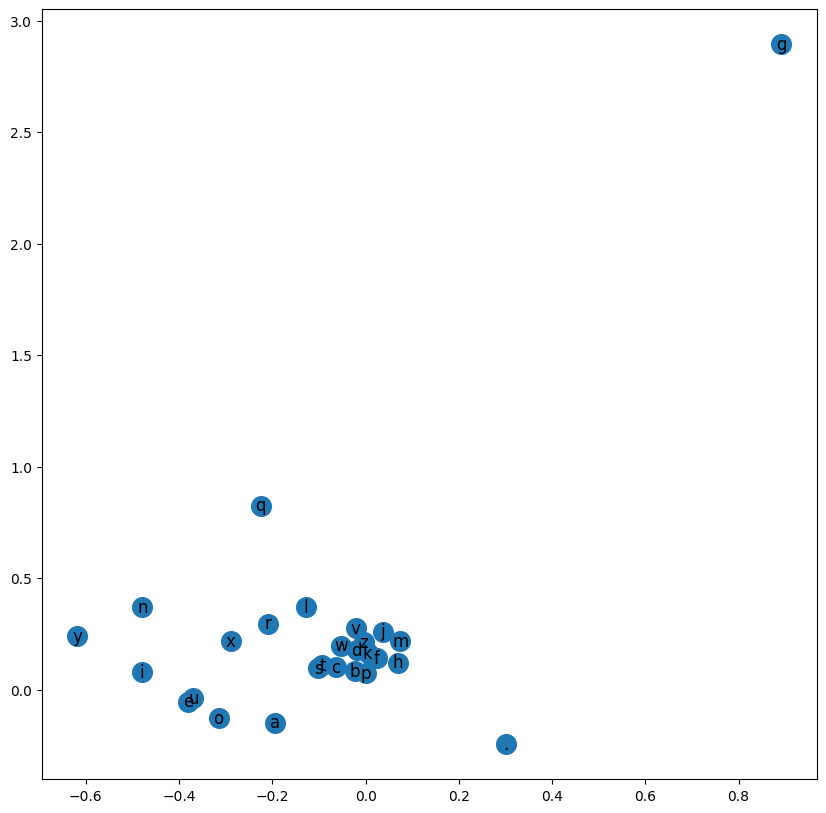

In [136]:
def visualise_emb():
    plt.figure(figsize=(10, 10))
    plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
    for i in range(C.shape[0]):
        plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha='center', va='center', fontsize=12, color='black')
    plt.grid(which='minor')

visualise_emb()